## Importamos las librerias necesarias

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Cargamos los datos y los preprocesamos

In [2]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):
    """
    Vizualize the distribution of the dataset.
  
    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category 
 
    Returns:
        No value
    """

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="#Images");
    ax.grid()


def load_data(data_path):
    """
    Load the dataset to the memory.
  
    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts
   
    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders = os.listdir(data_path)
    #Avoid problems with DS_Store file on MacOS
    if '.DS_Store' in subfolders:
        subfolders.remove('.DS_Store')

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []
    width = 48 
    eigth = 48
    dsize = (width, eigth)

    for category in subfolders:
        img_list=os.listdir(data_path +'/'+ category)

        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            face_array=cv2.resize(pixels, dsize, fx=1, fy=1,interpolation = cv2.INTER_CUBIC)

            img_data_list.append(face_array)          
            labels_list.append(category)

        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels, 7)

    data_visualization(subfolders, num_images_per_class)
    
    data = np.array(img_data_list)
    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 7215 images of category happy
Loading : 4830 images of category sad
Loading : 4097 images of category fearful
Loading : 4965 images of category neutral
Loading : 3995 images of category angry
Loading : 436 images of category disgusted
Loading : 3171 images of category surprised

Total number of uploaded data:  28709 , with data shape (48, 48, 3)


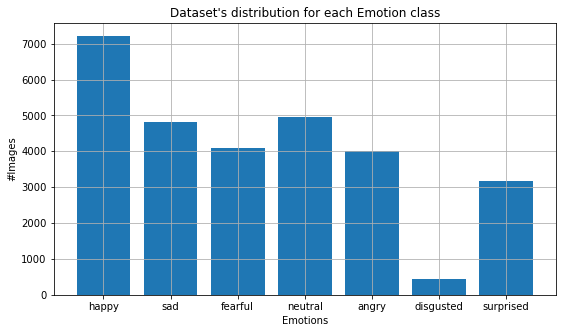

In [3]:
training_path = "FER_Dataset/train"
train_data, train_labels = load_data(training_path)

[INFO] Dataset Loading...

Loading : 1774 images of category happy
Loading : 1247 images of category sad
Loading : 1024 images of category fearful
Loading : 1233 images of category neutral
Loading : 958 images of category angry
Loading : 111 images of category disgusted
Loading : 831 images of category surprised

Total number of uploaded data:  7178 , with data shape (48, 48, 3)


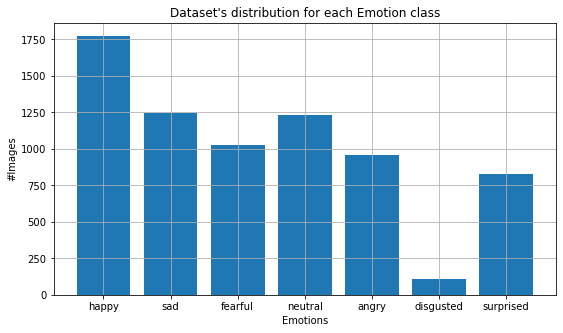

In [4]:
test_path = "FER_Dataset/test"
test_data, test_labels = load_data(test_path)

In [5]:
train_data.shape

(28709, 48, 48, 3)

In [6]:
train_labels.shape

(28709, 7)

In [7]:
# Split the dataset into two subsets (70%-30%). The first one will be used for training.
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, shuffle=True, random_state=3)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

# The second subset will be split into validation and test set (50%-50%).
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=3)

print(f"X_valid has shape: {X_valid.shape}")
print(f"y_valid has shape: {y_valid.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_valid + X_test = {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (20096, 48, 48, 3)
y_train has shape: (20096, 7)

X_valid has shape: (4306, 48, 48, 3)
y_valid has shape: (4306, 7)

X_test has shape: (4307, 48, 48, 3)
y_test has shape: (4307, 7)

X_train + X_valid + X_test = 28709 samples in total


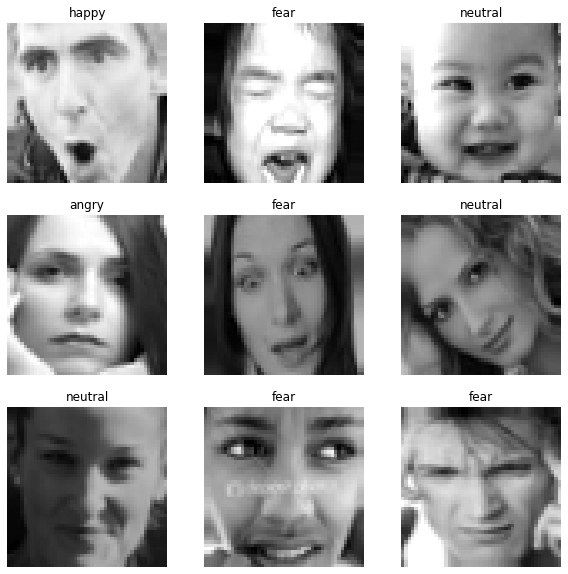

In [8]:
# Map the emotion-categories
mapping = {0:'happy', 1:'sad', 2:'fear', 3:'neutral', 4:'angry', 5:'disgusted', 6:'surprise'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              #width_shift_range=0.2,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              #height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 9:
        break

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")



In [16]:
def build_model():
    inputs = Input(shape=(48, 48, 3))
    base_model = EfficientNetB0(include_top=False, weights='imagenet',
                                drop_connect_rate=0.33, input_tensor=inputs)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(.5, name="top_dropout")(x)
    outputs = Dense(7, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
    """"model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 48x48 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.summary()

    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model"""

In [17]:
model = build_model()

In [ ]:
EPOCHS = 100
batch_size = 64

# Define the necessary callbacks
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [earlystopping, rlrop]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_valid, y_valid),
                 epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100
295/314 [===========================>..] - ETA: 7s - loss: 1.6445 - accuracy: 0.3696